# PyTorchでAutoEncoderを実装する
本資料は、以下の資料に日本語のコメントを追加したものです。  
**DS-GA 1008 · SPRING 2020 · NYU CENTER FOR DATA SCIENCE**  
URL: https://atcold.github.io/pytorch-Deep-Learning/  
URL: https://atcold.github.io/pytorch-Deep-Learning/ja/ (日本語)  
**pytorch-Deep-Learning**  
URL: https://github.com/Atcold/pytorch-Deep-Learning  
**10-autoencoder.ipynb**  
URL: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/10-autoencoder.ipynb


# Google ColaboratoryにおけるGPUランタイムの設定

1. 接続をクリックする。  
2. 接続できるとRAMとディスクの容量が表示される。  
3. ランタイムから「ランタイムのタイプの変更」。GPUを選択して保存する。
4. コマンド nvidia-smi を使用してGPUのステータスを確認する。

In [1]:
!nvidia-smi

Mon Jun 27 07:00:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PyTorchのバージョンの確認

In [2]:
# pytorchを仮にインポートしてバージョンを確認する
!python -c 'import torch; print(torch.__version__) '

1.11.0+cu113


# モジュールのインポート
ここではいくつかのモジュールをインポートします。モジュール(module)とは、クラスや関数を定義したファイルのことです。これは以下のいずれかの記述により実現される。

1.   import構文
2.   from A import B 構文
3.   from A import B as C 構文 

In [3]:
# PyTorchのインポート
import torch

# 処理デバイス名を設定する。
# GPUを使うなら cuda:0 ←複数台のGPUがある場合、番号を指定する。
# CPUを使うなら cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 使用するモジュール
## torchvision
URL: https://github.com/pytorch/vision  
"The torchvision package consists of popular datasets, 
model architectures, and common image transformations for computer vision."  
実験用のデータセットが含まれるほか、以下のような機能を有する。  
Transform, Classification, Semantic Segmentation, Object Detection,
Video Classification, Opticalflow, ...

## nn
URL: https://github.com/torch/nn  
"This package provides an easy and modular way to build and train simple
or complex neural networks using Torch"  
以下のような機能を有する。  
2,3-dimensional convolution, max pooling, linear, ReLU, softmax, ...。

## DataLoader
URL: https://pytorch.org/docs/stable/data.html  
DataLoaderを使うことでミニバッチ処理が簡単に実行できる。

## Transforms
URL: https://pytorch.org/vision/0.9/transforms.html  
NNを実行する前の前処理における変形などの機能を含む。

## MNIST
URL: https://pytorch.org/vision/stable/datasets.html  
手書き文字データベースMNISTを読み込む。

## matplotlib
URL: https://github.com/matplotlib/matplotlib  
ここでは2次元画像の描画に使用する。

In [4]:
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

# 前処理

### ミニバッチ処理のサイズの設定
* ミニバッチ処理  
学習には、①バッチ学習、②オンライン学習、③ミニバッチ学習がある。膨大な学習データがある場合、そのデータからランダムにN個を選択し、そのN個を用いて損失関数を演算子、その結果から学習する。これを繰り返すことですべての学習データを処理する方法がミニバッチ学習である。メリット: １件ずつ学習する（オンライン学習）よりも安定的である。学習データ内に含まれる例外的な異常データから受ける影響を抑制できる（オンライン学習に比べて）。デメリット: メモリ使用量はオンライン学習よりも大きい。

### 入力画像に対する前処理の定義
* ToTensor  
読み込んだ画像の配列情報（例えばnumpy型）をTensor型に変換する。値を[0.0-1.0]の範囲に変換する。
* Normalize  
画素値を指定された平均値と標準偏差で正規化する。x_new = (x - mean) / std。mean=0.5, std=0.5 の場合 x_new = 2x - 1 となる。つまり、値を[-1.0, 1.0]の範囲に変換する（ここでは活性化関数 tanh の値域[-1.0, 1.0]に合わせるため）。

In [5]:
# ミニバッチのサイズを決める
batch_size = 256

# 入力画像に対する前処理の定義
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# データベースの読み込み
dataset = MNIST('./data', transform=img_transform, download=True)

# 学習時に使いやすいようにDataLoaderにデータセットとバッチサイズを設定。
# shuffle - True: 取り出すミニバッチが毎回変わる
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# MNISTデータベースの画像の確認（その１）
データベースから画像を１枚選択し、matplotlibモジュールを用いてグレースケールで表示する。
1. 画像と、画像に対する正解ラベルの組を取得し、画像のサイズと正解ラベルを表示する。
2. 画像のみをグレースケールで表示する（オプションの cmap を gray に設定）。その他のオプションは以下を参照のこと。  

**Reference**  
Choosing Colormaps in Matplotlib  
URL: https://matplotlib.org/stable/tutorials/colors/colormaps.html


Image size is torch.Size([1, 28, 28]) Label is 5


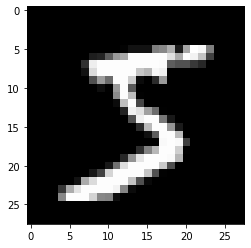

In [6]:
# 1枚取り出す（画像と、ラベル(0,1,...,9のいずれか）のセット）
img, lbl = dataset[0]
print("Image size is", img.size(), "Label is", lbl)

# 表示領域を生成
fig = plt.figure()
# [1,28,28]なので[28,28]の画像として表示
plt.imshow(img[0,:,:], cmap="gray") # グレースケールで表示

# MNISTデータベースの画像の確認（その２）
データベースから画像を複数枚選択し、matplotlibモジュールを用いてグレースケールで表示する（ここでは１０枚を表示）。

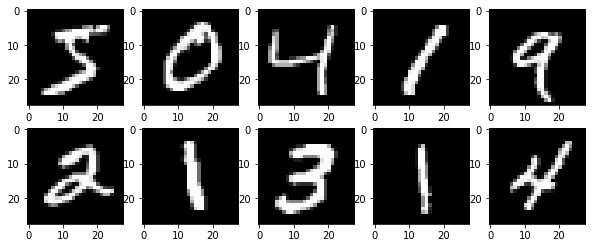

In [7]:
# 画像を複数枚表示
fig = plt.figure(figsize=(10,4))
# 反復構造で画像を順に並べて表示
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(dataset[i][0][0,:,:], cmap="gray") # グレースケールで表示

# モデルアーキテクチャと再構成ロスの定義と生成
隠れ層に1層の全結合層を持つシンプルなアーキテクチャ。  
**Linear**  全結合層    
URL: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html  
*in_features* – サンプル単位の入力サイズ。ここでは28x28の画像が入力されるので 28x28=784 となる。  
*out_features* - サンプル単位の出力サイズ。ここでは変数 *d* によって指定される。  
**Tanh** 活性化関数（Hyperbolic Tangent (Tanh) function）  
URL: URL: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
  




In [8]:
# n = 28 x 28 = 784
d = 30  # for standard AE (under-complete hidden layer)
# d = 500  # for denoising AE (over-complete hidden layer)

# オートエンコーダのクラス定義
class Autoencoder(nn.Module):
    # インスタンス生成時の初期化処理。
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# モデルの生成
model = Autoencoder().to(device)
# 損失の生成
criterion = nn.MSELoss()

# 関数定義：処理結果を表示可能画像へ変換
**Funcion Name**: to_img()  
**Argument**: x - 推定結果   
活性化関数 Tanh() の出力 [-1.0, 1.0] を [0.0, 1.0] に変換する。

In [9]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28) # view関数を使って28×28の画像を生成。
    return x

# 関数定義：画像をタイル状に表示
**Funcion Name**: display_images()  
**Argument**:  
in_ : 入力画像配列(例えばAEの入力画像用)  
out : 入力画像配列(例えばAEの出力画像用)  
n : 表示する画像は 4*n。与えられない場合は 1 となる。  

In [10]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        # 入力画像 in_ は与えられた場合のみ表示する。
        if in_ is not None:
            in_pic = to_img(in_.cpu().data) # ベクトルデータをCPU用に取り出して画像化。
            plt.figure(figsize=(18, 6)) # 横18×縦6インチの画像領域を生成。
            # 入力画像 in_ の0,1,2,3番目の画像を繰り返し表示。
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N]) # カラー表示。
                plt.axis('off') # 軸表示なし
                
        # 入力画像 out はいつも表示する。
        out_pic = to_img(out.cpu().data) # ベクトルデータをCPU用に取り出して画像化
        plt.figure(figsize=(18, 6))
        # 入力画像 out の0,1,2,3番目の画像を繰り返し表示 。
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N]) # カラー表示。
            plt.axis('off')

# 学習率および最適化手法の設定
**Adam** Adaptive Moment Estimation   
URL: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html  

In [11]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

# 学習および学習過程の表示
学習の反復回数は num_epochs に設定する。  
**zero_grad** 最適化対象のすべてのテンソルの勾配を0で初期化する。  
URL: https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html  

In [15]:
# Train standard or denoising autoencoder (AE)

num_epochs = 5
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')

epoch [1/5], loss:0.0736
epoch [2/5], loss:0.0661
epoch [3/5], loss:0.0680
epoch [4/5], loss:0.0646
epoch [5/5], loss:0.0567


# 学習結果の表示

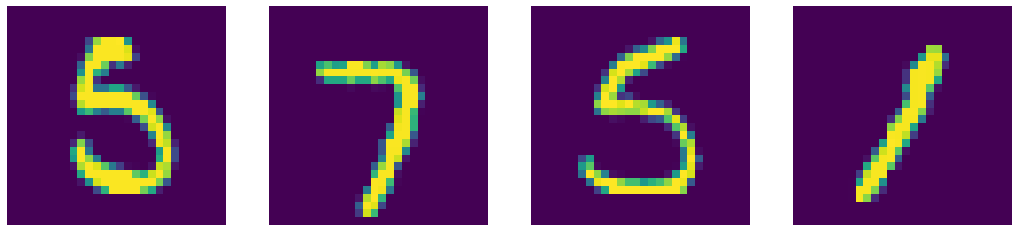

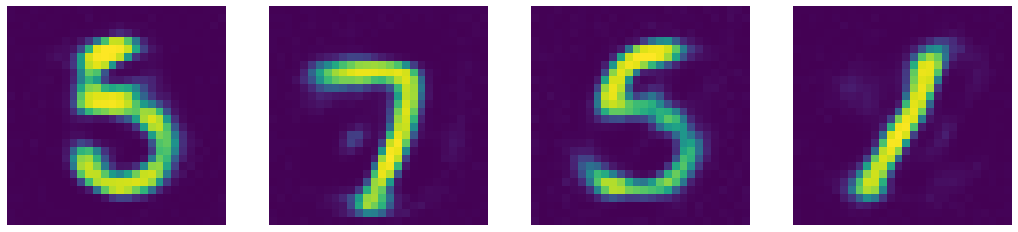

In [16]:
display_images(img, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

# AEにおける重みの一部を表示

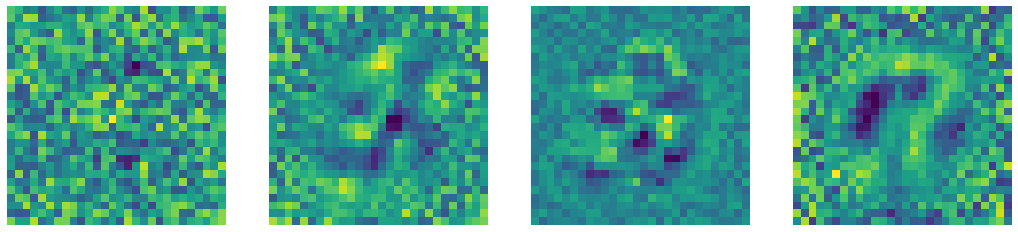

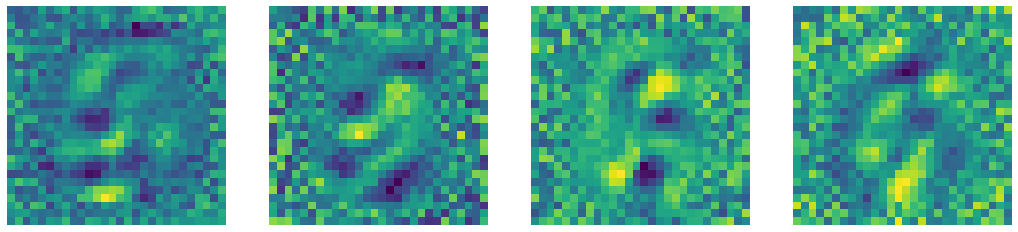

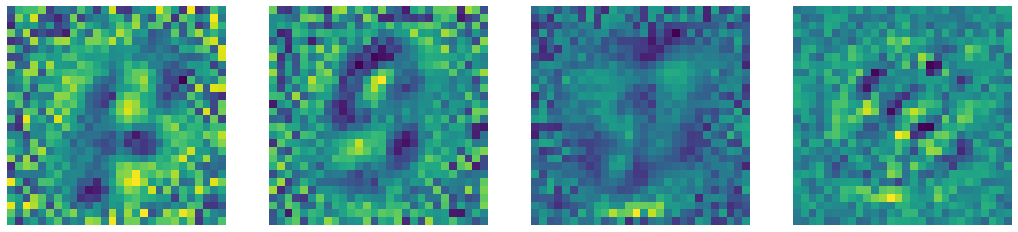

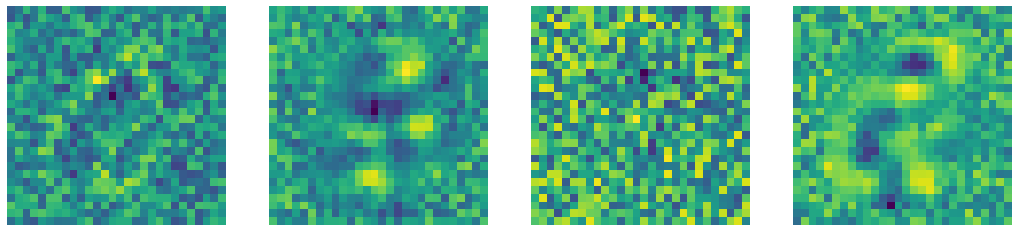

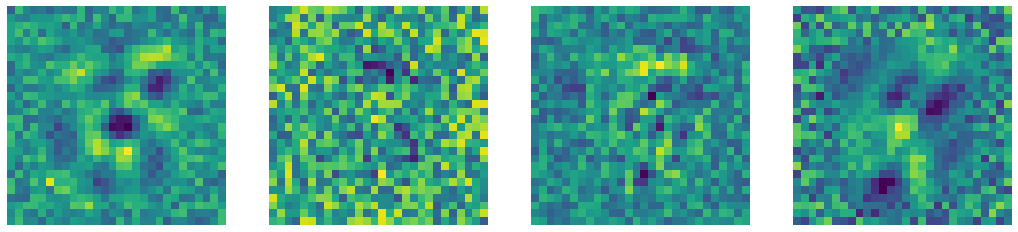

In [14]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder[0].weight, 5)